In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import healpy as hp

import yaml

from Qatmosphere_2d import Atmsophere

import scipy
import scipy.special as sci_spe
import time
from astropy.time import TimeDelta
 
import sys
import yaml

sys.path.append('/home/laclavere/qubic/qubic/Pipeline')

import qubic
from qubic.lib.Qscene import QubicScene

from pyoperators.iterative.core import AbnormalStopIteration
from pysimulators import (
    CartesianEquatorial2GalacticOperator,
    CartesianEquatorial2HorizontalOperator,
    CartesianHorizontal2EquatorialOperator,
    CartesianGalactic2EquatorialOperator,
    SamplingHorizontal,
    SphericalEquatorial2GalacticOperator,
    SphericalGalactic2EquatorialOperator,
    SphericalEquatorial2HorizontalOperator,
    SphericalHorizontal2EquatorialOperator)
from pysimulators.interfaces.healpy import Cartesian2HealpixOperator, Spherical2HealpixOperator
from pyoperators import *

%matplotlib inline

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
with open('/home/laclavere/Documents/Thesis/qubic/qubic/scripts/Atmosphere/params.yml', 'r') as file:
    params = yaml.safe_load(file)

In [3]:
atm = Atmsophere(params)

(196608,)
(4, 196608)


In [23]:
qubic_patch =qubic.lib.Qsamplings.equ2gal(0, -57)

In [17]:
atm_maps = atm.get_maps()
frequencies = atm.integrated_absorption_spectrum()[1]

(196608,)
(4, 196608)


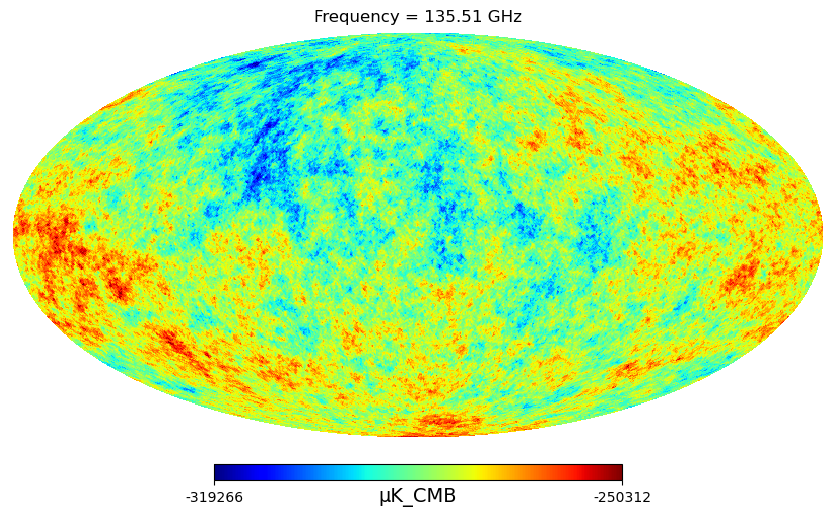

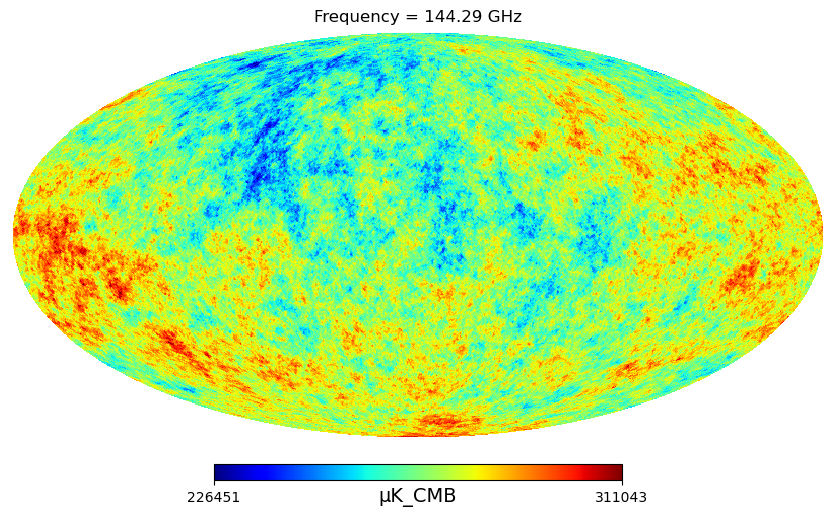

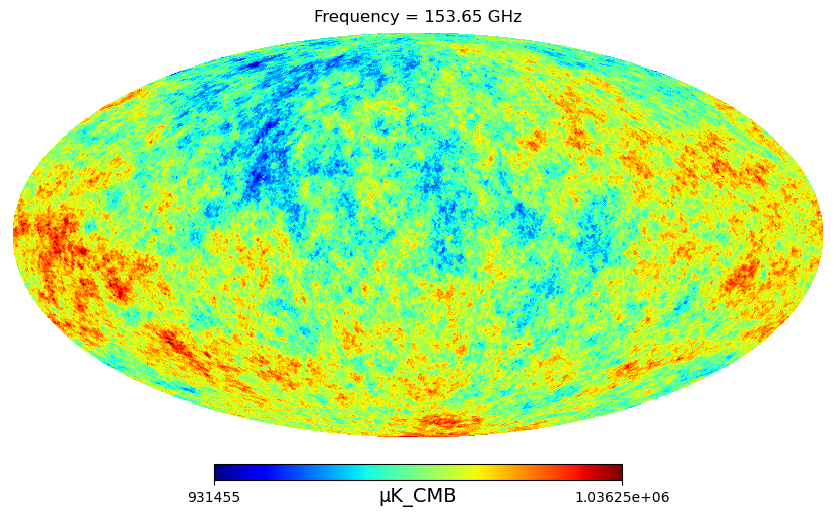

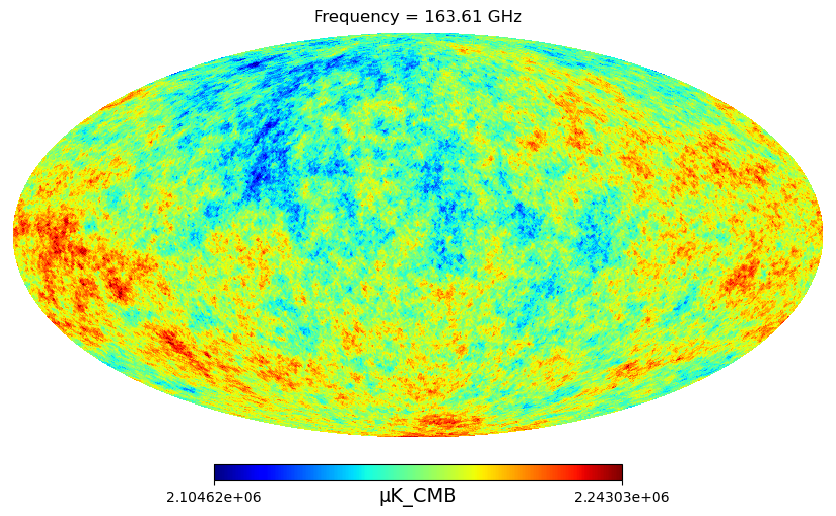

In [21]:
for i in range(len(frequencies)):
    hp.mollview(atm_maps[i], title='Frequency = {:.2f} GHz'.format(frequencies[i]), unit='µK_CMB', cmap='jet')
plt.tight_layout()
plt.show()

In [22]:
from qubic.scripts.MapMaking.src.FMM.model.planck_timeline import InputMaps
from pyoperators import *
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

In [14]:
cmb_maps = InputMaps({'cmb':42}, atm.frequencies, 2, params['nside']).m_nu

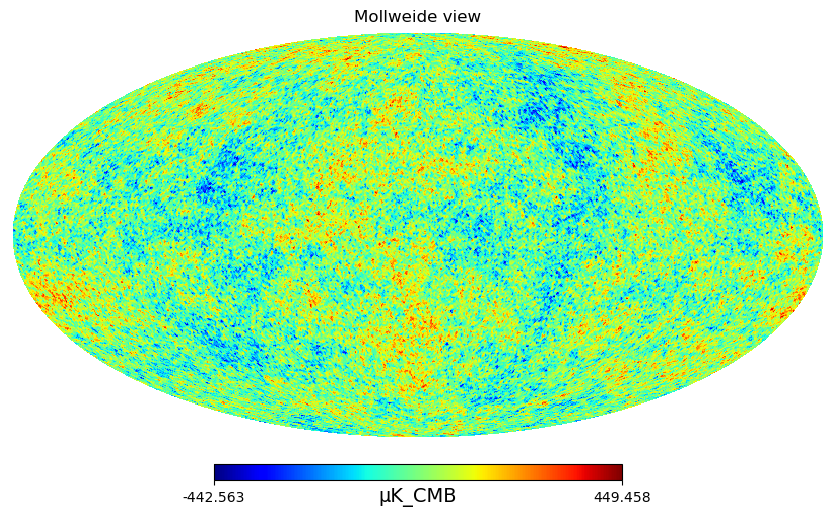

In [15]:
hp.mollview(cmb_maps[-1, :, 0],cmap='jet', unit='µK_CMB')

In [19]:
input_maps = cmb_maps.copy()
input_maps[:, :, 0] += atm_maps

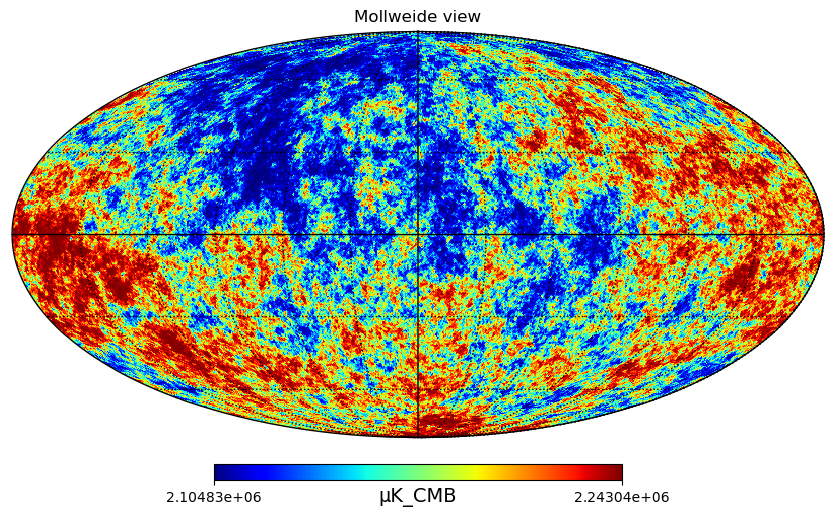

In [20]:
hp.mollview(input_maps[-1, :, 0] ,cmap='jet', unit='µK_CMB', norm='hist')
hp.graticule()


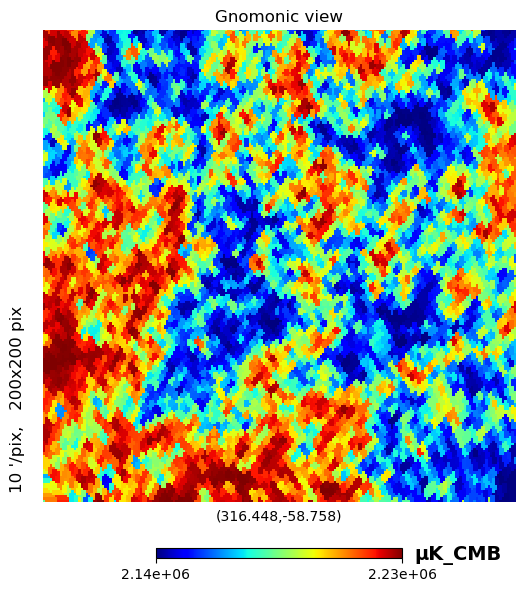

In [24]:
hp.gnomview(input_maps[-1, :, 0], cmap="jet", unit="µK_CMB", norm="hist", reso=10, rot=qubic_patch) 

# Map-making

In [27]:
Qacq = qubic.lib.InstrumentModel.Qacquisition.QubicDualBand(atm.qubic_dict, nsub=params['nsub_in'], nrec=params['nrec'])
H = Qacq.get_operator(fwhm=Qacq.allfwhm)
invN = Qacq.get_invntt_operator()

You asked 1000 pointings with repeat strategy so I will provide 333 pointings repeated 3 times.
Info apcnb2325: Allocating (991008,9) elements = 136.09423828125 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (991008,9) elements = 136.09423828125 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (991008,9) elements = 136.09423828125 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (991008,9) elements = 136.09423828125 MiB in FSRRotation3dMatrix.__init__.


In [28]:
#coverage = joint.qubic.subacqs[0].get_coverage()
coverage = Qacq.coverage
npix_qubic=0
for i in coverage:
    if i!=0:
        npix_qubic+=1
covnorm = coverage / coverage.max()
seenpix = covnorm > 0.1
fsky = seenpix.astype(float).sum() / seenpix.size
coverage_cut = coverage.copy()
coverage_cut[~seenpix] = 1

mask = np.ones(12*params['nside']**2)
mask[seenpix] = 0

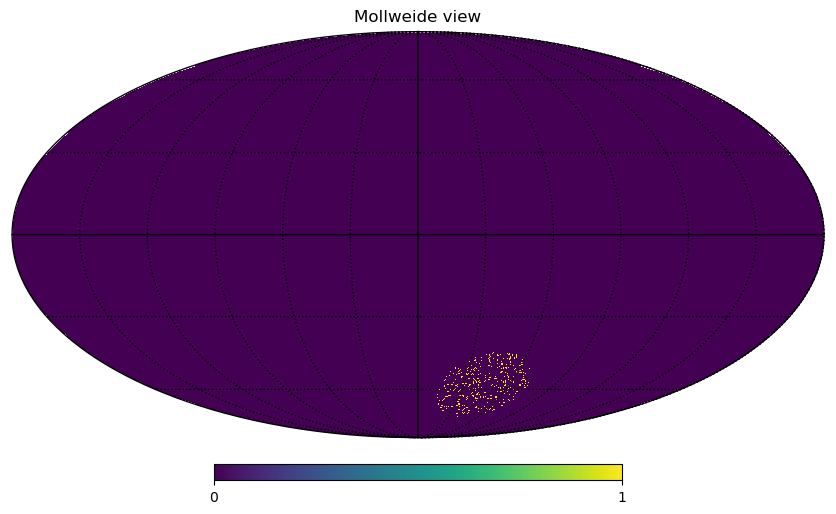

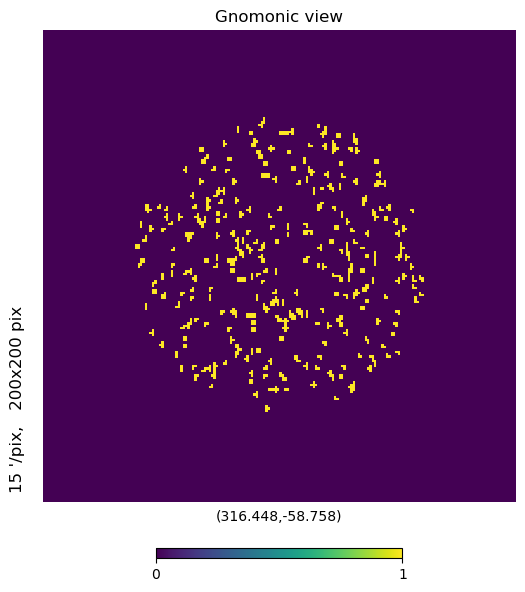

In [29]:
test_index = Qacq.sampling.healpix(atm.params['nside'])
test_hp = np.zeros(12*atm.params['nside']**2)
for i in test_index:
    test_hp[int(i)] = 1
hp.mollview(test_hp)
hp.graticule()
hp.gnomview(test_hp, rot=qubic_patch, reso=15)

In [30]:
A = H.T * invN * H
b = H.T * invN * H(input_maps)
x0 = input_maps #+ 1e3 * np.random.randn(input_maps.shape[0], input_maps.shape[1], input_maps.shape[2])  

In [31]:
approx_hth = np.zeros((input_maps.shape))
conditioner = np.zeros((input_maps.shape))
vec = np.ones(Qacq.H[0].shapein)

for i in range(input_maps.shape[0]):
    for j in range(input_maps.shape[0]):
        approx_hth[i] = (
            Qacq.H[i].T
            * Qacq.invn220
            * Qacq.H[j](vec)
        )
fsub_out = int(params["nsub_in"] / params["nrec"])
for irec in range(params["nrec"]):
    imin = irec * fsub_out
    imax = (irec + 1) * fsub_out
    for istk in range(3):
        conditioner[irec, seenpix, istk] = 1 / (
            np.sum(approx_hth[imin:imax, seenpix, 0], axis=0)
        )

conditioner[conditioner == np.inf] = 1
M = DiagonalOperator(conditioner)

In [32]:
import time
from qubic.lib.Qcg import PCGAlgorithm
time0 = time.time()
algo = PCGAlgorithm(
    A,
    b,
    comm,
    x0=x0,
    tol=1e-10,
    maxiter=50,
    disp=True,
    M=M,
    center=center,
    reso=15,
    seenpix=seenpix,
    input=input_maps,
)
try:
    output = algo.run()
    success = True
    message = 'Success'
except AbnormalStopIteration as e:
    output = algo.finalize()
    success = False
    message = str(e)

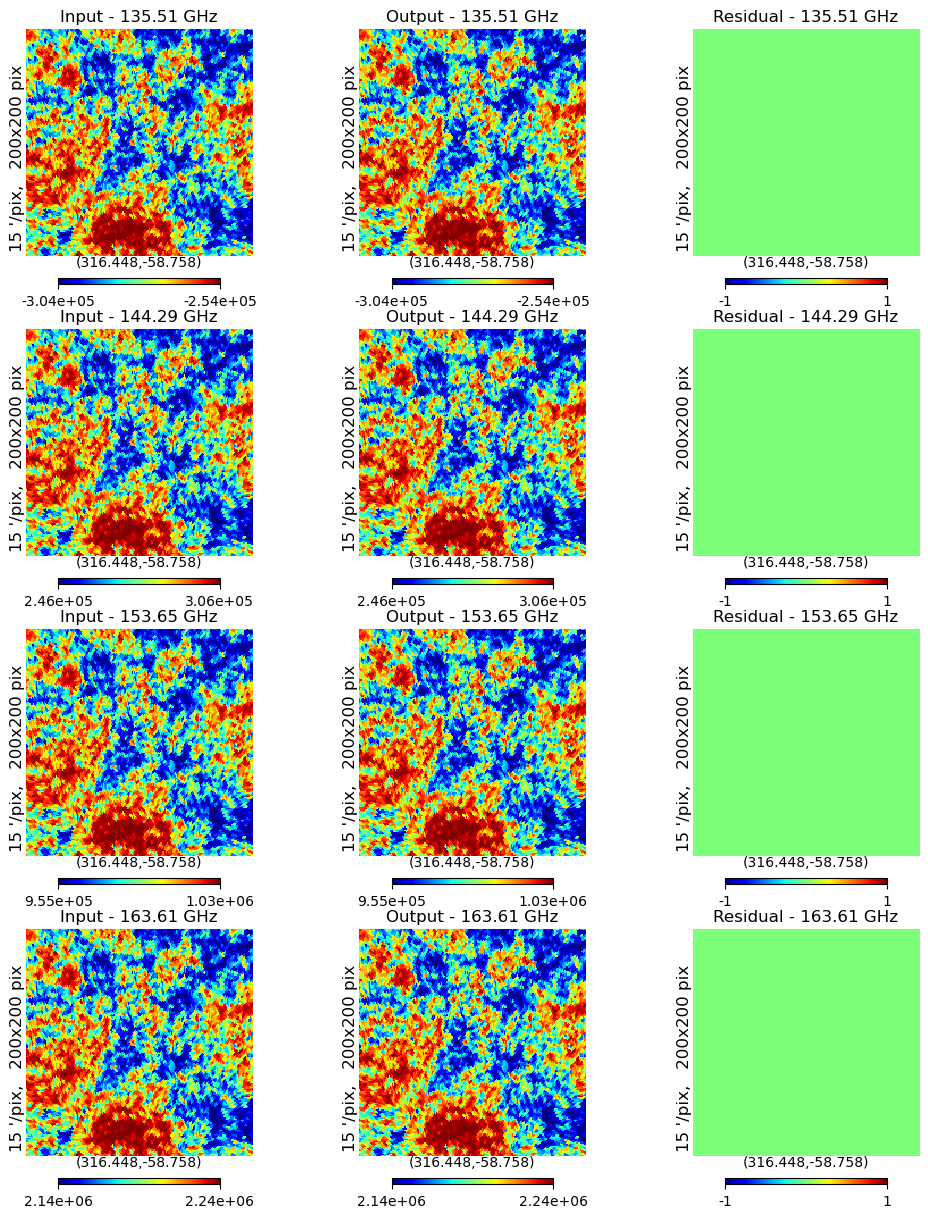

In [33]:
plt.figure(figsize=(10, 12))
k=1
for inu in range(output['x'].shape[0]):
    hp.gnomview(input_maps[inu, :, 0], norm='hist', cmap='jet', rot=qubic_patch,title='Input - {:.2f} GHz'.format(atm.frequencies[inu]), reso=15, sub=(output['x'].shape[0], 3, k))
    hp.gnomview(output['x'][inu, :, 0], norm='hist', cmap='jet', rot=qubic_patch,title='Output - {:.2f} GHz'.format(atm.frequencies[inu]), reso=15, sub=(output['x'].shape[0], 3, k+1))
    hp.gnomview(output['x'][inu, :, 0] - input_maps[inu, :, 0], norm='hist', cmap='jet', rot=qubic_patch,title='Residual - {:.2f} GHz'.format(atm.frequencies[inu]), reso=15, sub=(output['x'].shape[0], 3, k+2))
    k+=3

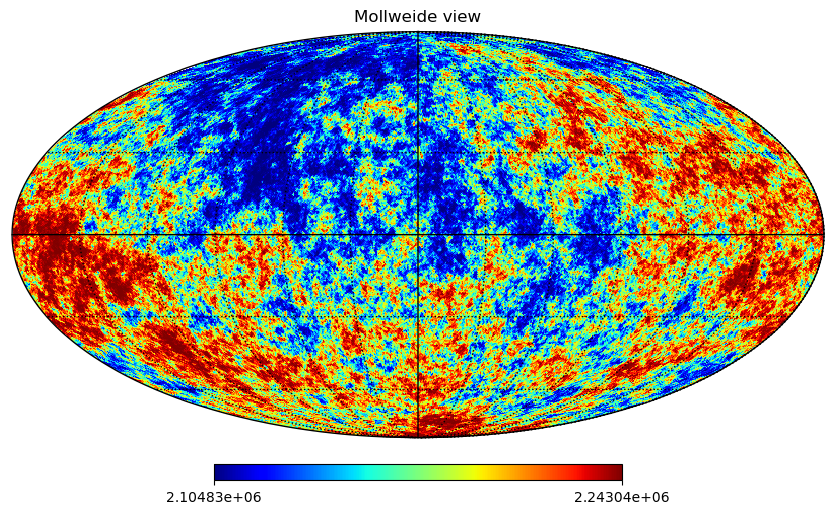

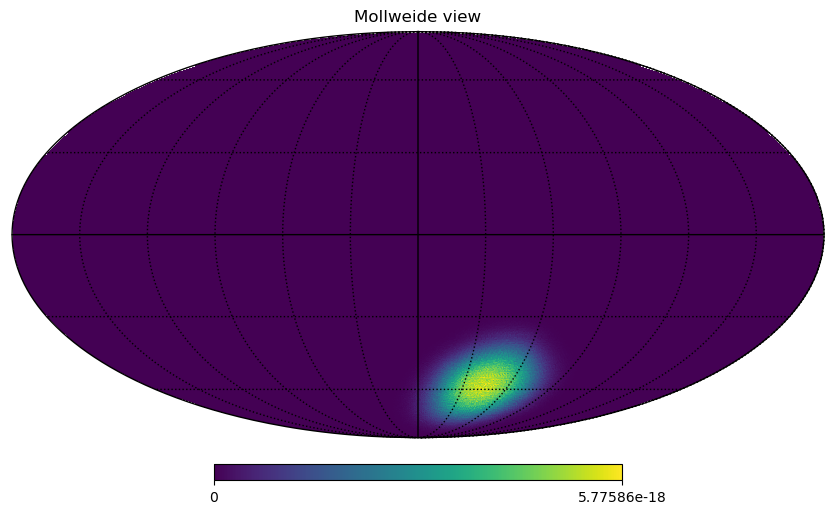

In [34]:
hp.mollview(output['x'][-1, :, 0], cmap='jet', norm='hist')
hp.graticule()
hp.mollview(coverage)
hp.graticule()

In [194]:
stop

NameError: name 'stop' is not defined

In [13]:
from lib.InstrumentModel.Qacquisition import QubicMultiAcquisitions

ModuleNotFoundError: No module named 'lib'

In [10]:
def get_dict(params, comm, key='in'):
    """QUBIC dictionary.

    Method to modify the qubic dictionary.

    Parameters
    ----------
    key : str, optional
        Can be "in" or "out".
        It is used to build respectively the instances to generate the TODs or to reconstruct the sky maps,
        by default "in".

    Returns
    -------
    dict_qubic: dict
        Modified QUBIC dictionary.

    """

    args = {
        "npointings": params["QUBIC"]["npointings"],
        "nf_recon": params["QUBIC"]["nrec"],
        "nf_sub": params["QUBIC"][f"nsub_{key}"],
        "nside": params["SKY"]["nside"],
        "MultiBand": True,
        "period": 1,
        "RA_center": params["SKY"]["RA_center"],
        "DEC_center": params["SKY"]["DEC_center"],
        "filter_nu": 150 * 1e9,
        "noiseless": False,
        "comm": comm,
        "dtheta": params["QUBIC"]["dtheta"],
        "nprocs_sampling": 1,
        "nprocs_instrument": comm.Get_size(),
        "photon_noise": True,
        "nhwp_angles": 3,
        #'effective_duration':3,
        "effective_duration150": 3,
        "effective_duration220": 3,
        "filter_relative_bandwidth": 0.25,
        "type_instrument": "two",
        "TemperatureAtmosphere150": None,
        "TemperatureAtmosphere220": None,
        "EmissivityAtmosphere150": None,
        "EmissivityAtmosphere220": None,
        "detector_nep": float(params["QUBIC"]["NOISE"]["detector_nep"]),
        "synthbeam_kmax": params["QUBIC"]["SYNTHBEAM"]["synthbeam_kmax"],
    }

    ### Get the default dictionary
    dictfilename = "dicts/pipeline_demo.dict"
    dict_qubic = qubic.lib.Qdictionary.qubicDict()
    dict_qubic.read_from_file(dictfilename)

    for i in args.keys():

        dict_qubic[str(i)] = args[i]

    return dict_qubic